# Manipulating fMRI data for MEL test

## Loading the data

In [2]:
import bhfunc2025 as bh
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.input_data import NiftiMasker, NiftiMapsMasker
import numpy as np
import pandas as pd
from pathlib import Path

In [3]:
# the path where nilearn downloads reference data, the default will be '~/nilearn_data' if you leave None
ref_data_dir = '/Users/hycheng/Desktop/MS/113-2/BH/final_project/refDLdata'
    
# Loading the functional datasets
# data = datasets.fetch_development_fmri(n_subjects=1, data_dir=ref_data_dir)

# you can use the .keys() method to check what's in the dataset
# data.keys()

# We can check the description of the dataset to know what we're dealing with 
# print(data.description)

In [4]:
# data.func contains the paths to the Nifti files (the files containing fMRI data)
# fmri_filepath = data.func[0]
fmri_filepath = 'ses-00/sub-17/func/F1/mswaF1_ep2d_moco_4mm_240_1-6_20230621131135_6.nii'
beh_filepath = 'ses-00/sub-17/beh/sub17_run1_2023_Jun_21_1324.csv'
subject, run = 17, 1 # for output of the extracted activity

In [5]:
# We can load a Nifti file with the nibabel library
fmri_img = nib.load(fmri_filepath)
print(fmri_img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (79, 95, 79, 188)
affine:
[[   2.    0.    0.  -78.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -70.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  79  95  79 188   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  2.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 672
glmin           : 0
descrip         : b'Warped - conv(8,8,8)'
aux_file        : b''
qform_code     

So this is a `Nifti1Image` object which contains 3 things :
* some data of shape (79, 95, 79, 188)
* an affine array that defines the spatial orientation and scale of the data
* a header, containing more information about the data format

Note that the data is a 4D array. The last dimension is the time, so we have 188 volumes, and from the 5th value of the pixdim array in the header we can see that the t_r is 2s, so we have a file that represents 336s of scanning. 

For each time point we have a 3D array that contains the voxels. But not all these voxels correspond to the brain.

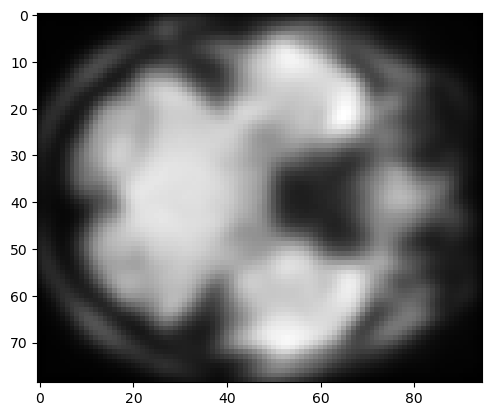

In [7]:
# get the data array 
fmri_data = fmri_img.get_fdata()
# plt.plot(fmri_data[25,30,25]) # plot time series from a single coxel

# plot a transversal slice of brain for the 71st time point at z=25
plt.imshow(fmri_data[:,:,25,70], cmap='gray')

In [8]:
# the behavior DataFrame correspond to the scan
beh_summary = pd.read_csv(beh_filepath)

# list the tiral timestamps
o_onset_img = bh.extract_ts(beh_summary, 'o_onset')
p_onset_img = bh.extract_ts(beh_summary, 'p_onset')
cond = bh.extract_ts(beh_summary, 'maincond', num=False)
hit = bh.extract_ts(beh_summary, 'hit', num=False)

print(cond)

['os', 'od', 'ts', 'td', 'os', 'ts', 'od', 'ts', 'ts', 'od', 'td', 'os', 'td', 'ts', 'os', 'td', 'od', 'od', 'td', 'td', 'ts', 'od', 'os', 'os']


## Masking the data

The masker not only removes the background voxels, but it can also regress out the confounds if you provide them.

In short, the confounds are external sources of signal you want to remove, such as the movement of the head. Regressing out the confounds means removing the part of the signal correlated to the sources of noise. For example we can remove the part of the signal that correlates with the head motion because we consider this part of signal to be only artefacts caused by the movements and not relevant for brain activity. 

Confounds handling is in reality more complicated than that, if you want to learn more you can check the [fMRIprep documentation](https://fmriprep.org/en/stable/outputs.html#confounds).

In [10]:
masker = NiftiMasker(target_affine=fmri_img.affine)
masked_data = masker.fit_transform(fmri_filepath, confounds=None)
masked_data.shape

[NiftiMasker.wrapped] Resampling images

/opt/anaconda3/lib/python3.12/site-packages/joblib/memory.py:312: UserWarning: Casting data from int16 to float32
  return self.func(*args, **kwargs)


(188, 592871)

Also note that we kept 32,504 voxels, when whe had a total of 50 * 59 * 50 = 147,500, so we got rid of a lot of empty voxels. That is good, but the downside is that we lost the spatial information of where these voxels are in the brain. But don't worry because the masker remembers it. If we want to recover this information and turn back our 1D arrays into 3D spatial ones we can uste the `makser.inverse_transform` method.

(188, 592871)
(79, 95, 79, 188)


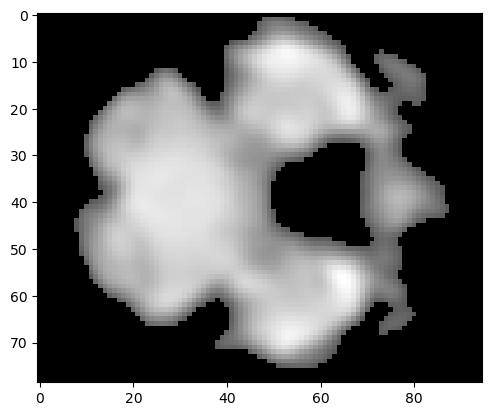

In [12]:
# threshold fMRI data by the mean and plot the result
thresholded_masked_data = masked_data * (masked_data > masked_data.mean())
print(thresholded_masked_data.shape)
thresholded_img = masker.inverse_transform(thresholded_masked_data)
print(thresholded_img.shape)
plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')

## Using an atlas

Having removed the empty voxels is great, and we could directly compute a connectome on the masked data,
but it would create a 32,504 by 32,504 matrix, which would be a bit hard to analyse.

An easier way to manipulate the data would be to use an atlas, that defines region of interest (ROIs). We could create our own atlas by clustering the voxels, but hopefully nilearn provides ready-made atlases, let's load one.

In [14]:
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=ref_data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels

atlas_regname = pd.read_csv('refDLdata/msdl_atlas/MSDL_rois/msdl_rois_labels.csv')

[get_dataset_dir] Dataset found in /Users/hycheng/Desktop/MS/113-2/BH/final_project/refDLdata/msdl_atlas

We now have the path to the Nifti file containing the ROIs info in `atlas_filepath` and the names of the ROIs in `labels`.

To apply the atlas on our data, we can once again use a masker, but this time a `NiftiMapsMasker`.

In [16]:
atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True,
                               resampling_target="data")

data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=None)# fmri_img.confounds
data_in_atlas.shape

(188, 39)

We see that now we only have 39 values per time point, so we have 39 ROIs. This is more appropriate to compute a connectivity matrix.

We can plot the time series in a ROI :

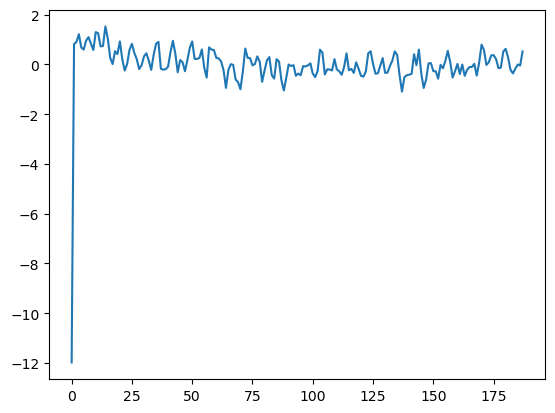

[0.6156250885799062, -1.2457938326754594, -1.477283738506467, -2.010540480743166, -0.5075334587384949, 1.5650727337830161, -0.32754951907396934, -0.7634124020577229, -2.75046141832383, 0.17446855955814952, -0.12712448507833202, -1.3281219252702323, -0.5292993824935217, -0.21588120667136113, -0.6274160389693022, -1.5599087118153572, -0.5718920286457636, -0.9231113838537088, -0.2641782508925547, -1.1877053776715845, -0.8833949841934234, -0.378511174231174, 1.117996721842593, -1.7082229230820056]


In [18]:
# plot the signals in (one of the) 39 brain region(s)
plt.plot(data_in_atlas[:,1])
plt.show()


# extract the activity
for i in range(39):
    region_diff = bh.extract_diff(data_in_atlas, o_onset_img, p_onset_img, reg_num=i)
    bh.CatNSave(region_diff, cond=cond, sub=subject, run=run, breg=atlas_regname['name'][i])
    
print(region_diff)

**Note**: Depending on the type of atlas you use, you might have to use different kinds of masker. Here we have probabilistic overlapping regions, so we use a `NiftiMapsMasker`, but if we had non-overlapping regions, we would use a `NiftiLabelsMasker`.

## Connectome

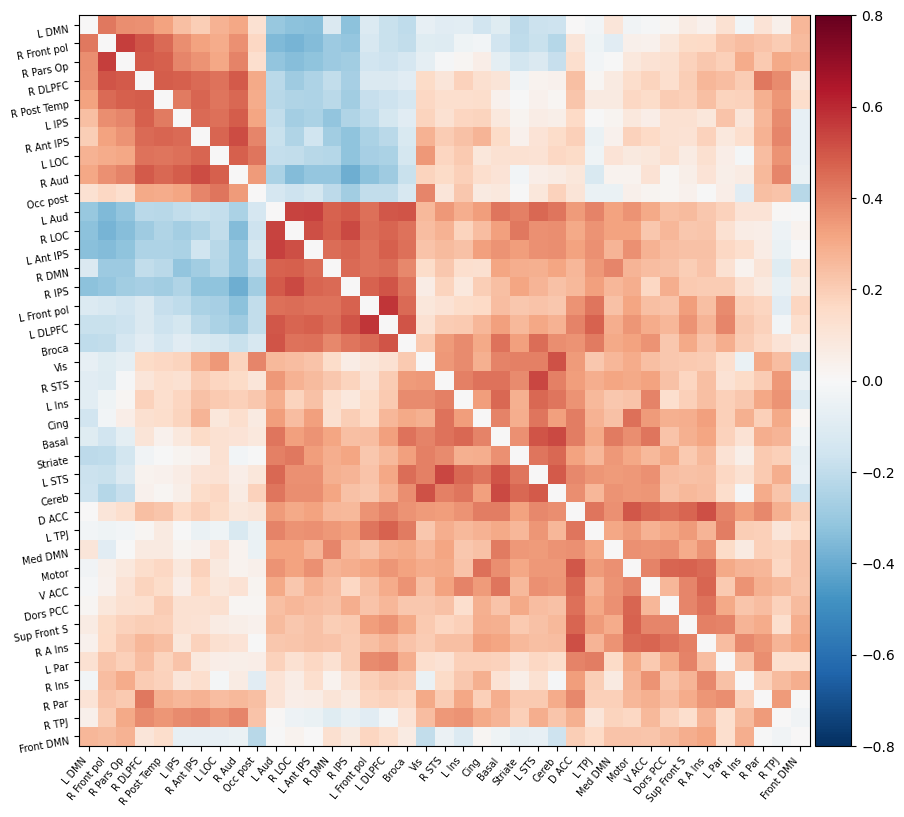

In [20]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix, make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# Matrix reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)
plt.show()

## Plotting

To discover more ways of generating super cool visuals of brains, check the [nilearn plotting documentation](https://nilearn.github.io/plotting/index.html).

Earlier we simply plotted a slice of our brain with matplotlib. It works and it is a fine way to check your data array. However for more complex or fancy plots, nilearn comes with a lot of handy tools in its `nilearn.plotting` module. Here are a few examples.

* To view a 3D NiftiImage object, the `view_img` functions makes it easy to interactively go through the slices.

/var/folders/9m/172vd1l95lzfrht66cqtl0lm0000gn/T/ipykernel_3251/52262985.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  fmri_img_mean = mean_img(fmri_img)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



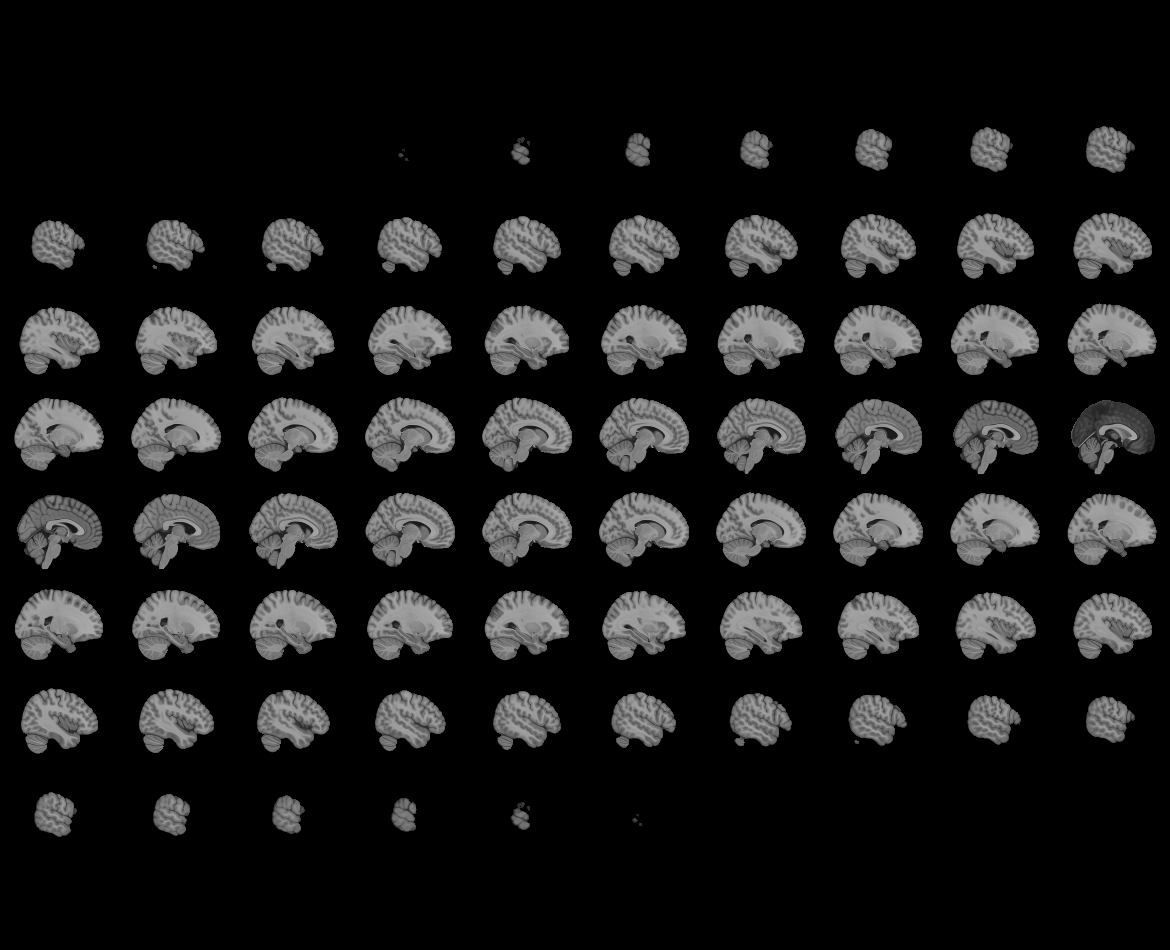
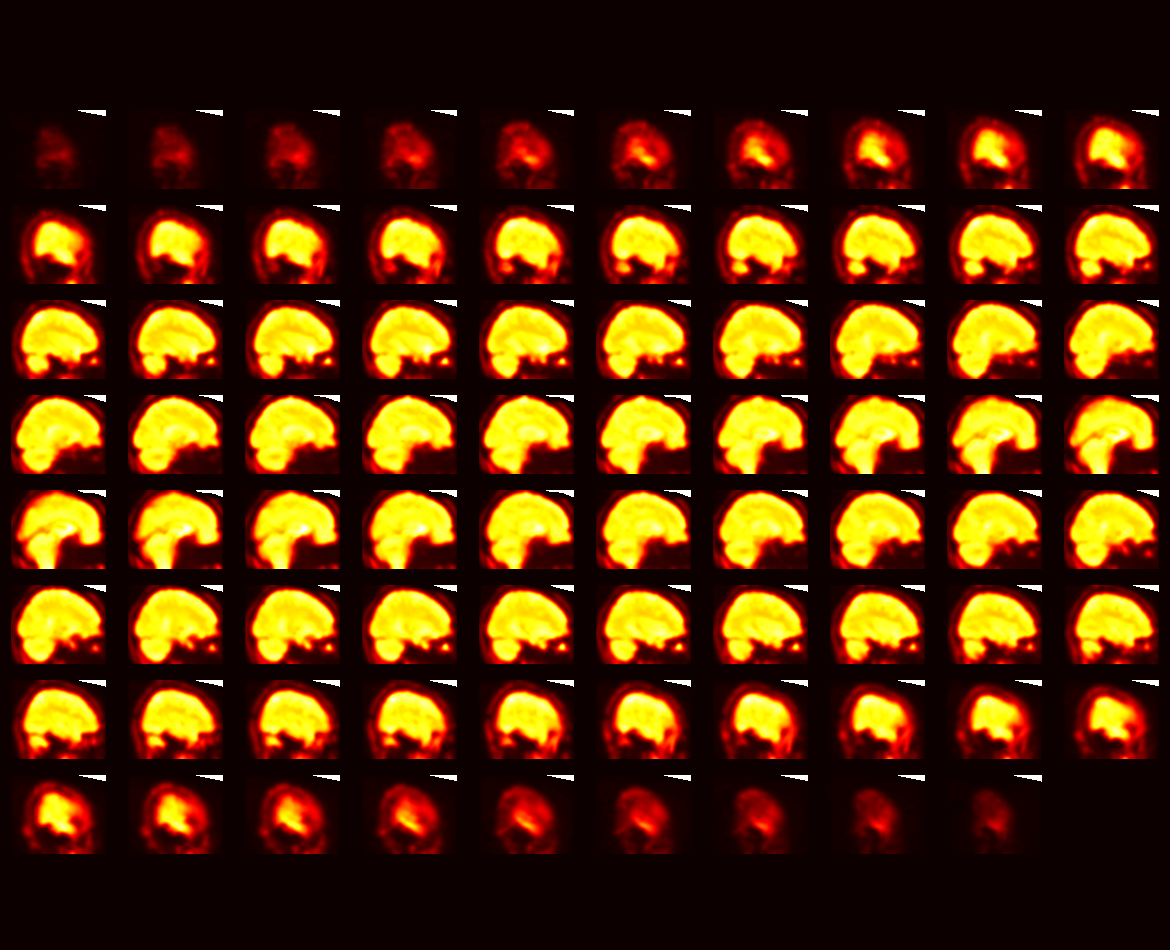

In [22]:
# Since our fmri_img is a 4D NiftiImage, we need to generate a 3D one.
# One way is averaging our volumes on the time axis with mean_img.
from nilearn.image.image import mean_img

fmri_img_mean = mean_img(fmri_img)
plotting.view_img(fmri_img_mean)

* To display the graph corresponding to a connectome, you can use `plot_connectome`.

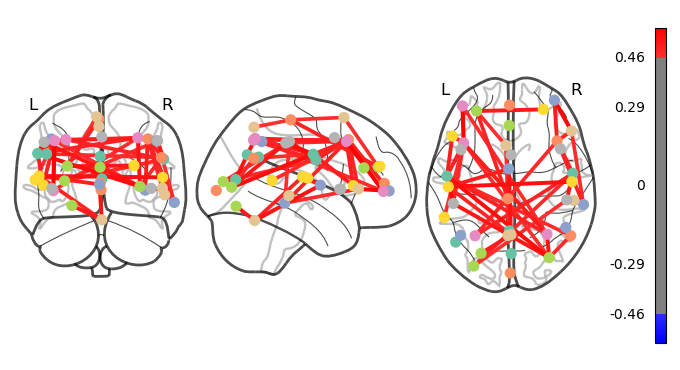

In [52]:
coords = atlas_dataset.region_coords

# We threshold to keep only the 10% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                edge_threshold="95%", colorbar=True)


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



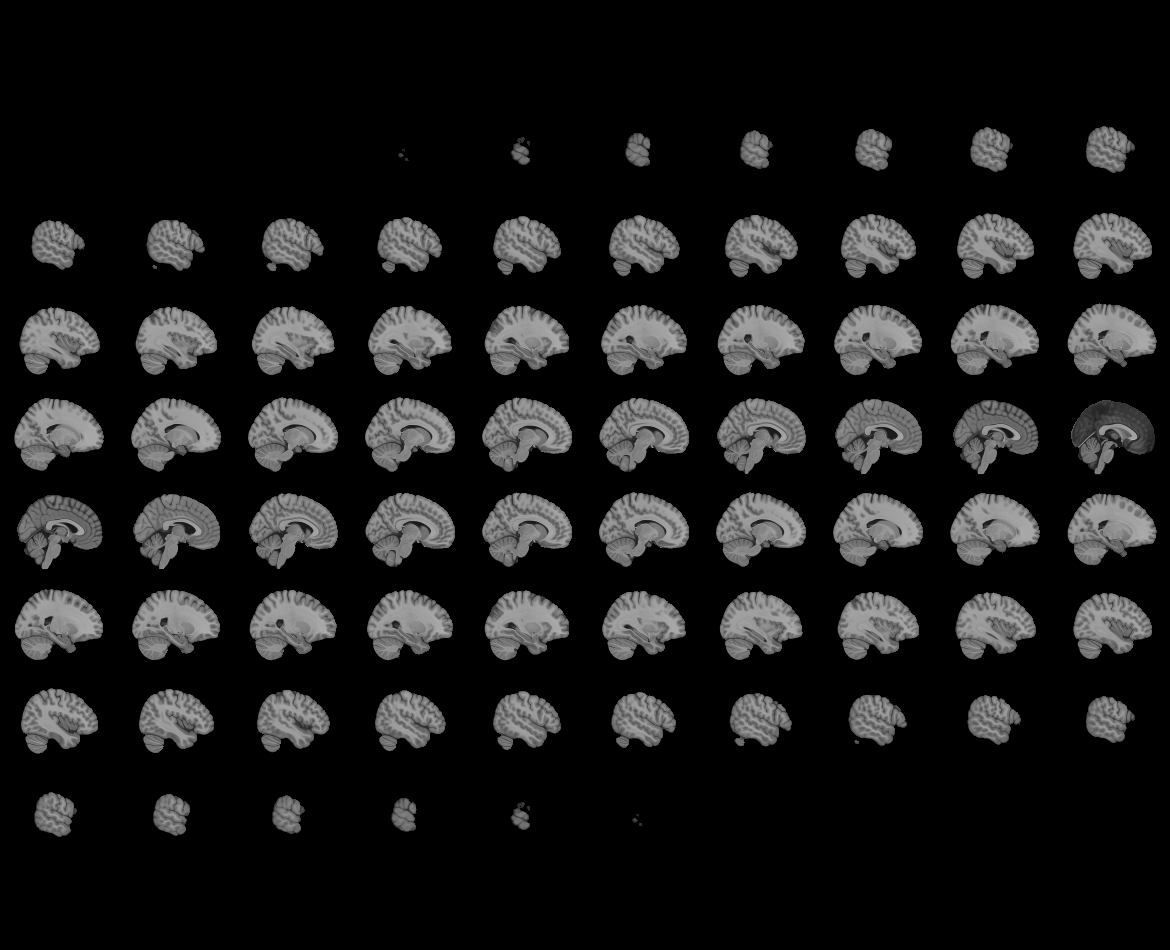
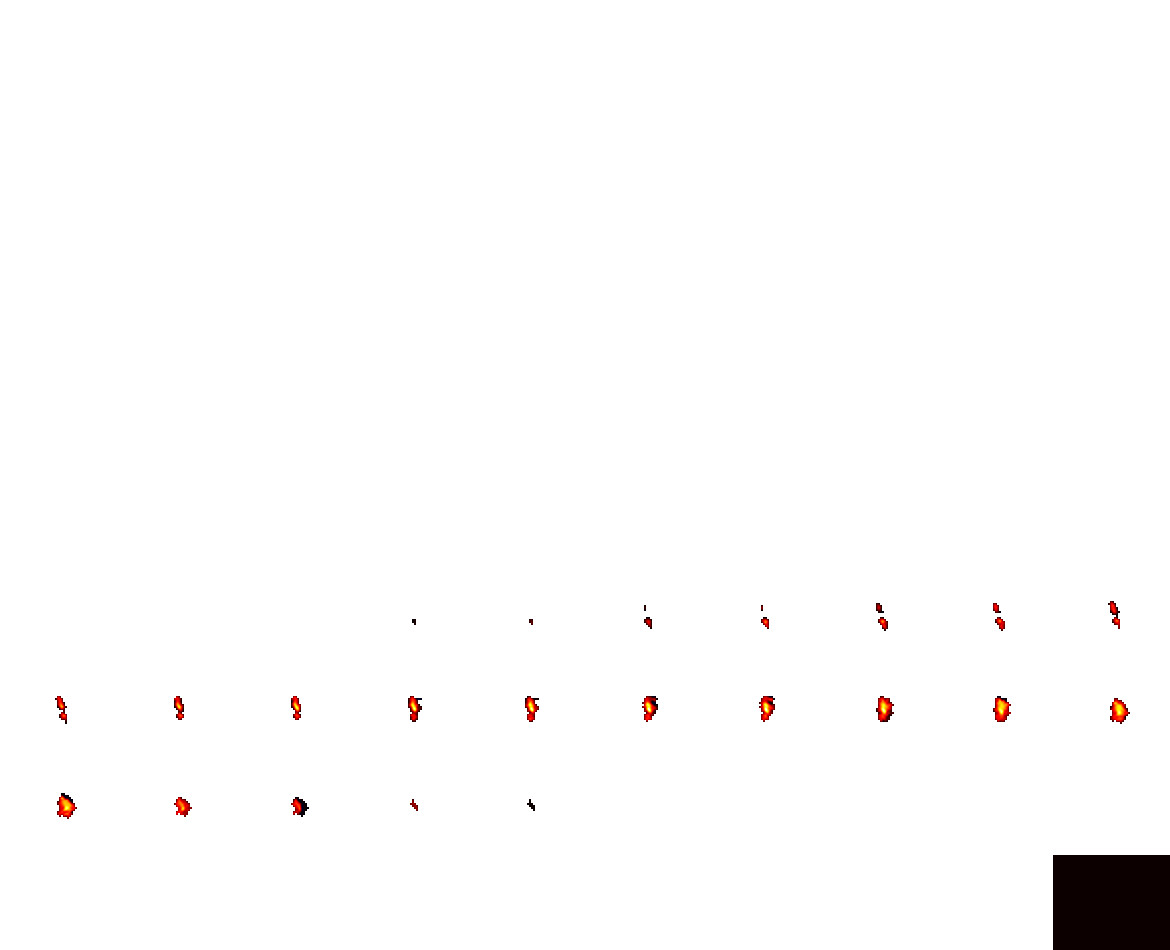

In [25]:
atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)

mask = np.zeros(39)
mask[1]=1
atlas_img = atlas_masker.fit_transform(fmri_filepath, confounds=None)
atlas_img = atlas_masker.inverse_transform(mask)

plotting.view_img(atlas_img)

In [26]:
# plotting.plot_prob_atlas(atlas_filepath, view_type='filled_contours')

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



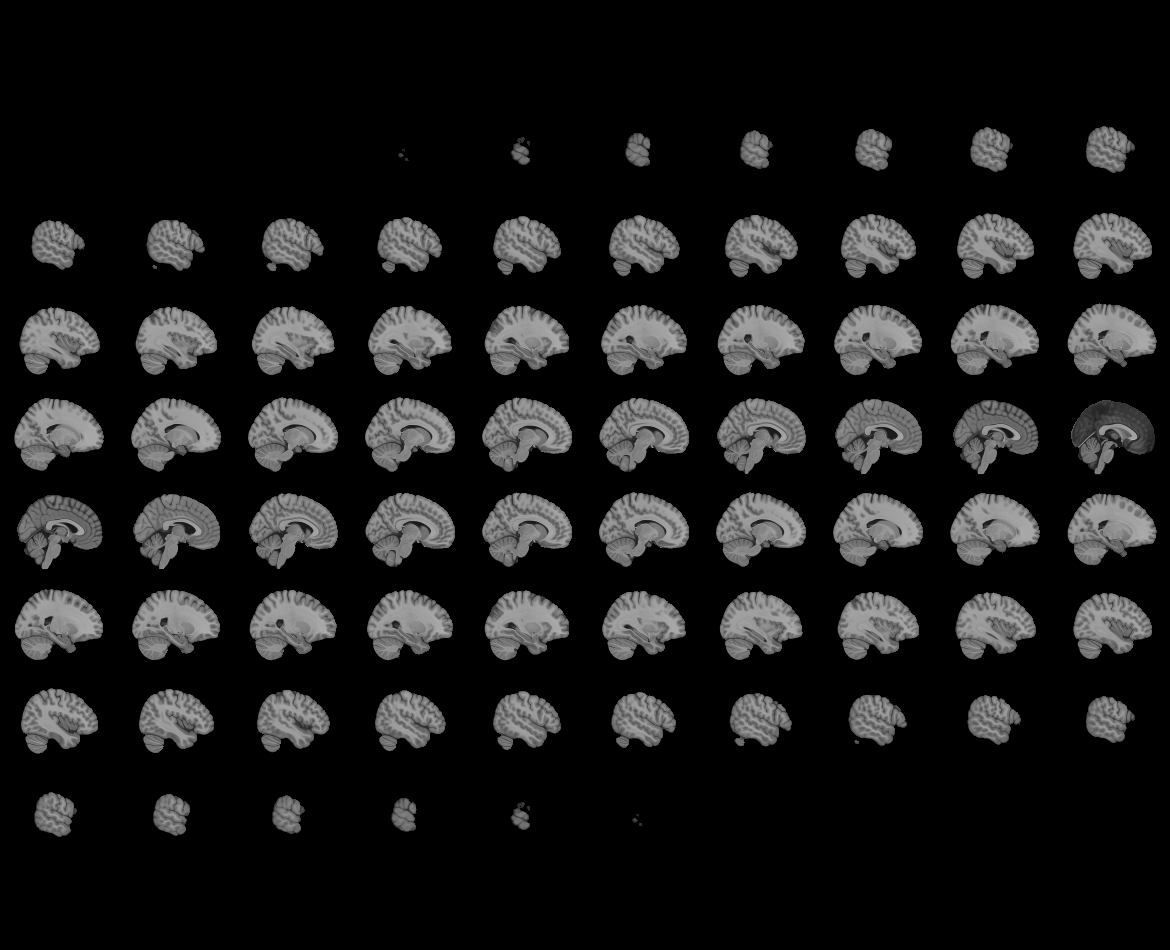
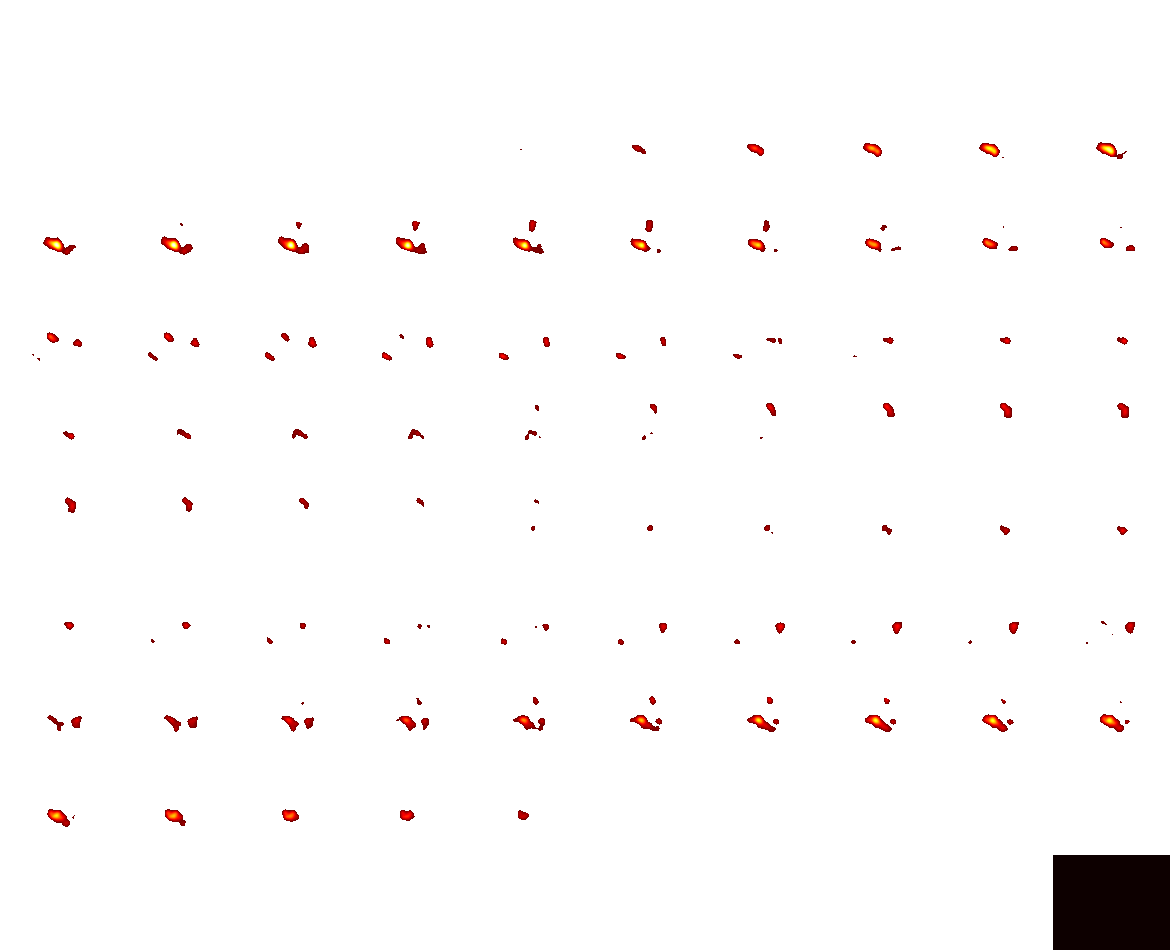

In [27]:
atlasH = nib.load('refDLdata/Auditory_WithManualExclusion_C05_1k_ALE.nii.gz')
atlasH_img = atlasH.get_fdata()
plotting.view_img(atlasH)
# type(atlasH)
# type(atlasH_img)

atlas_Hmasker = NiftiMapsMasker(maps_img=atlasH, standardize=True)
data_in_H = atlas_Hmasker.fit_transform(fmri_filepath, confounds=None)
# plt.plot(data_in_atlas[:,0])
# plt.show()
plotting.view_img(atlasH)

In [28]:
aud_gen_diff = bh.extract_diff(data_in_H, org_ts=o_onset_img, prb_ts=p_onset_img)
bh.CatNSave(aud_gen_diff, cond=cond, sub=subject, run=run, breg='GeneralAud')

0